# rl5E_tester.ipynb

This notebook is used to test networks produced by `rl5E_hyper.ipynb`.  
In practice this means that the network is created by the `rl5E_net` method, and that its configuration comes from a loaded parameter dictionary.

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from tools.visualization import plotter

/home/z/projects/draculab/notebook


In [2]:
%cd spinal/rl
from rl5E_from_cfg import rl5E_net

/home/z/projects/draculab/notebook/spinal/rl


In [3]:
# Load the results from a previous run of rl5E_hyper
%cd /home/z/projects/draculab/saves
fname = 'rl5E_hyper_2021-01-05__14_04_cns-amd.pkl'
with (open(fname, "rb")) as f:
    pop = pickle.load(f)
    f.close()

# If the results are form a run with fewer parameters
# fill it with the default values.
# for cfg in pop:
#     for name in ranges:
#         if not name in cfg:
#             cfg[name] = ranges[name]['default']

/home/z/projects/draculab/saves


In [4]:
# print some configurations
for dic in pop[0:3]:
    print('{',end='')
    for name in dic.keys():
        if name != 'fitness' or dic['fitness'] != None:
            print("\'%s\':%.2f, " % (name, dic[name]), end='')
    print('}\n')

pop[0]

{'C_sigma':0.70, 'V_slope':1.00, 'V_delta':1.77, 'V_thresh':0.30, 'X_slope':5.64, 'X_thresh':3.50, 'L__V_lrate':0.31, 'L__V_gamma':0.35, 'L__V_max_w':0.49, 'L__V_w_sum':17.67, 'L__X_lrate':0.15, 'L__X_w_sum':15.23, 'fitness':40.52, 'n_evals':1.00, 'C_slope':2.00, 'C_thresh':0.20, 'C_integ_amp':0.01, 'C_custom_inp_del':28.00, 'M_des_out_w_abs_sum':1.60, 'P_mu':0.50, 'P_inp_gain':2.00, 'R_thresh':4.00, 'R_slope':-1.00, 'A__M_lrate':5.00, 'A__M_w_sum':0.80, 'A__M_w_max':0.50, 'C__C_init_w':-1.50, 'M__C_lrate':100.00, }

{'C_sigma':0.70, 'V_slope':1.00, 'V_delta':0.60, 'V_thresh':0.30, 'X_slope':5.64, 'X_thresh':3.50, 'L__V_lrate':0.31, 'L__V_gamma':0.56, 'L__V_max_w':0.49, 'L__V_w_sum':17.67, 'L__X_lrate':0.60, 'L__X_w_sum':10.00, 'fitness':42.16, 'n_evals':2.00, 'C_slope':2.00, 'C_thresh':0.20, 'C_integ_amp':0.01, 'C_custom_inp_del':28.00, 'M_des_out_w_abs_sum':1.60, 'P_mu':0.50, 'P_inp_gain':2.00, 'R_thresh':4.00, 'R_slope':-1.00, 'A__M_lrate':5.00, 'A__M_w_sum':0.80, 'A__M_w_max':0.50,

{'C_sigma': 0.7,
 'V_slope': 1.0,
 'V_delta': 1.7650532568278374,
 'V_thresh': 0.3,
 'X_slope': 5.644507099686773,
 'X_thresh': 3.5,
 'L__V_lrate': 0.3075372570885423,
 'L__V_gamma': 0.35,
 'L__V_max_w': 0.48504352455131616,
 'L__V_w_sum': 17.671532180263412,
 'L__X_lrate': 0.14767111172514982,
 'L__X_w_sum': 15.228618741752737,
 'fitness': 40.51510304935321,
 'n_evals': 1,
 'C_slope': 2.0,
 'C_thresh': 0.2,
 'C_integ_amp': 0.01,
 'C_custom_inp_del': 28,
 'M_des_out_w_abs_sum': 1.6,
 'P_mu': 0.5,
 'P_inp_gain': 2.0,
 'R_thresh': 4.0,
 'R_slope': -1.0,
 'A__M_lrate': 5.0,
 'A__M_w_sum': 0.8,
 'A__M_w_max': 0.5,
 'C__C_init_w': -1.5,
 'M__C_lrate': 100.0}

In [6]:
# Create a network from one of the configurations in pop
cfg = pop[0]
net, pops_dict = rl5E_net(cfg, pres_interv=5, rand_w=False, par_heter=0.05)
for name in pops_dict:
    exec(name + '=' + str(pops_dict[name]))

In [7]:
# Setting, fixing controller weights
# limit values:
A__M_mat = np.array([[0.4, .5, 0.08, 0.018],
                    [0.05, 0. , 0.4, 0.5]])

M__C_mat = np.array([[0.,  2.15],
                     [2.15, 0.]])

for m_idx, m_id in enumerate(M):
    for c_idx, c_id in enumerate(C):
        syn_list = net.syns[c_id]
        for syn in syn_list:
            if syn.preID == m_id:
                syn.w = M__C_mat[c_idx, m_idx]
                syn.alpha = 1e-5 # slowing down learning
                break

for a_idx, a_id in enumerate(A):
    for m_idx, m_id in enumerate(M):
        syn_list = net.syns[m_id]
        for syn in syn_list:
            if syn.preID == a_id:
                syn.w = A__M_mat[m_idx, a_idx]
                syn.alpha = 1e-5 # slowing down learning
                break

In [ ]:
# Configure X switching
net.units[X[0]].switch = False
net.units[X[0]].sw_thresh = 0.02

In [9]:
net.units[X[0]].thresh = 0.

In [ ]:
sim_time = 1000.
#net.units[pops_dict['X'][0]].sw_thresh = 10. # stop switching
#net.units[pops_dict['X'][0]].thresh = cfg['X_thresh'] # restoring the threshold
#ratio = 15.1 # cns-amd
ratio = 10. # breaker
#ratio = 1.7 # breaker, no L,V
secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish at: %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

# import cProfile
# import pstats
# cProfile.run('times, data, plant_data = net.run(2.)', 'restats')
# prof = pstats.Stats('restats')
# prof.sort_stats('cumulative').print_stats(30)
# data = np.array(data)

Expecting to finish at: 20:7 (10000 seconds)


In [ ]:
sim_time = 5000.
#net.units[pops_dict['X'][0]].sw_thresh = 10. # stop switching
#net.units[pops_dict['X'][0]].thresh = cfg['X_thresh'] # restoring the threshold
#ratio = 15.1 # cns-amd
ratio = 10. # breaker
#ratio = 1.7 # breaker, no L,V
secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish at: %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

# import cProfile
# import pstats
# cProfile.run('times, data, plant_data = net.run(2.)', 'restats')
# prof = pstats.Stats('restats')
# prof.sort_stats('cumulative').print_stats(30)
# data = np.array(data)

In [18]:
# change length of presentation
net.units[SP[0]].set_function(lambda t: des_sf[int(round(t/15.))])

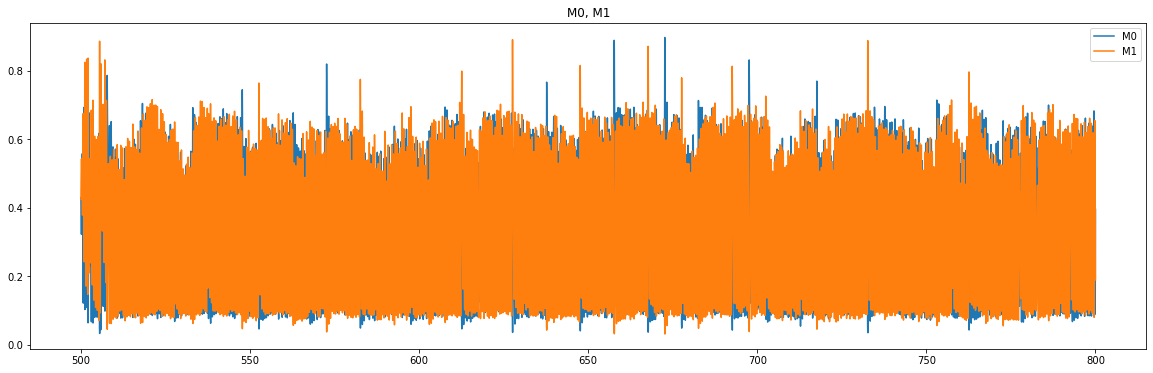

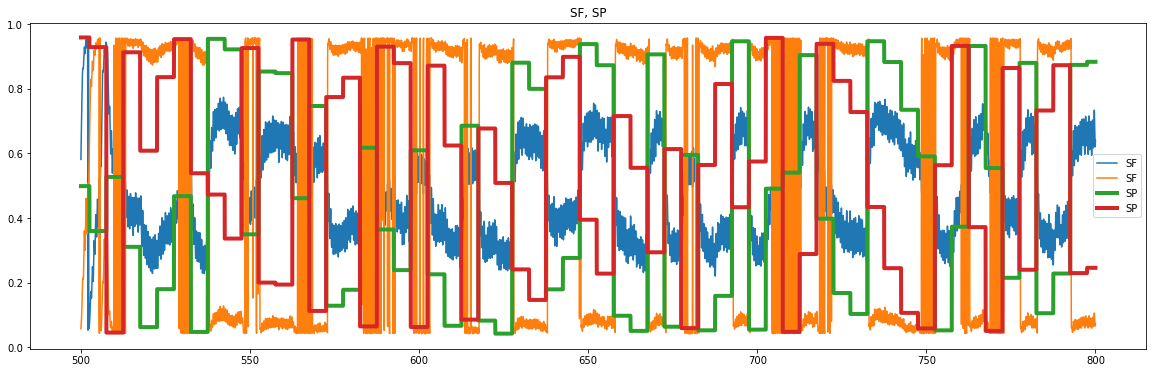

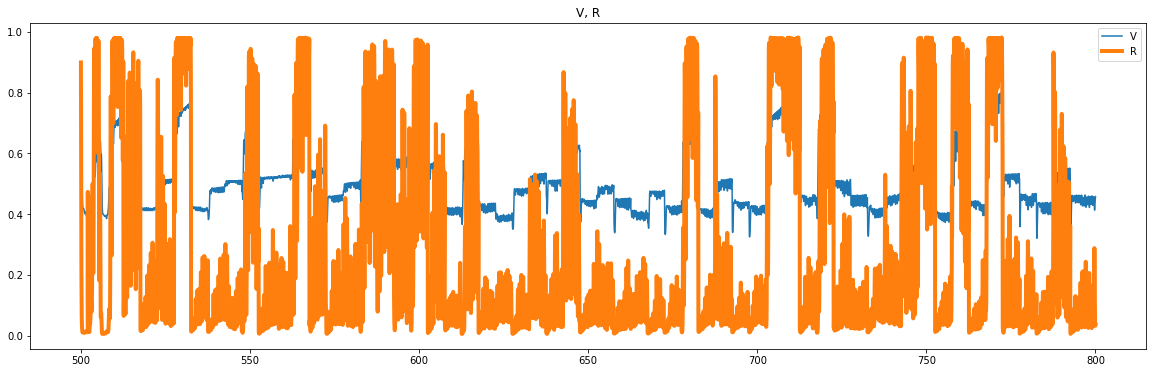

In [35]:
fs = (20,6)

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
plt.legend(['M0', 'M1'])
plt.title('M0, M1')
#print(M_data[:,-1])

# SF, SP
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='SF')
plt.plot(times, SP_data.transpose(), label='SP', linewidth=4)
plt.legend()
plt.title('SF, SP')
plt.show()
#print('SF = [%f]' % (SF_data[0,-1]))
#print('SP = [%f]' % (SP_data[0,-1]))

# V, R
V_fig = plt.figure(figsize=fs)
V_data = np.array(data[V])
plt.plot(times, V_data.transpose())
#plt.legend(['V'])
plt.title('V, R')
R_data = np.array(data[R])
plt.plot(times, R_data.transpose(), linewidth=4)
plt.legend(['V', 'R'])

# # M--C0 weights
# W_fig1 = plt.figure(figsize=fs)
# w_track_data = np.array(data[M_C0_track])
# plt.plot(times, w_track_data.transpose())
# plt.legend(['M0-C0', 'M1-C0'])
# plt.title('M--C0 weights')

# # A--M0 weights
# W_fig2 = plt.figure(figsize=fs)
# w_track_data2 = np.array(data[A_M0_track])
# plt.plot(times, w_track_data2.transpose())
# plt.legend(['A0-M0', 'A1-M0', 'A2-M0', 'A3-M0'])
# plt.title('A--M0 weights')

plt.show()

Text(0.5, 1.0, 'SPF')

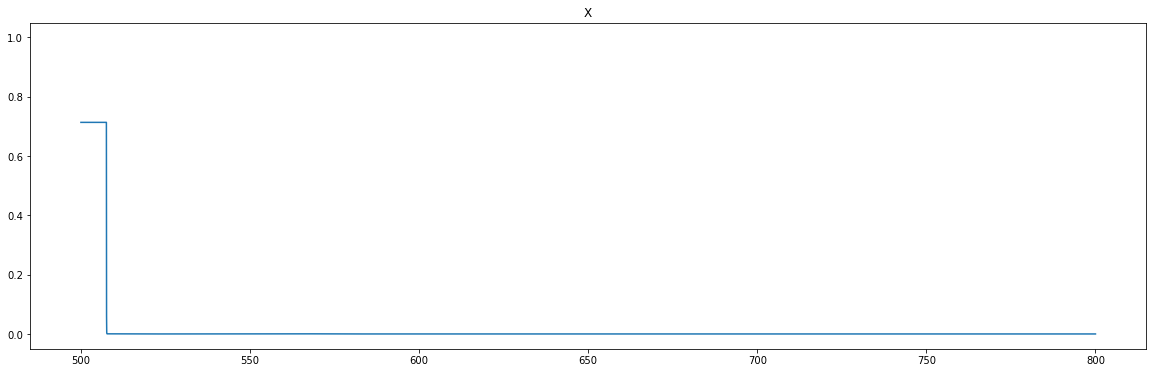

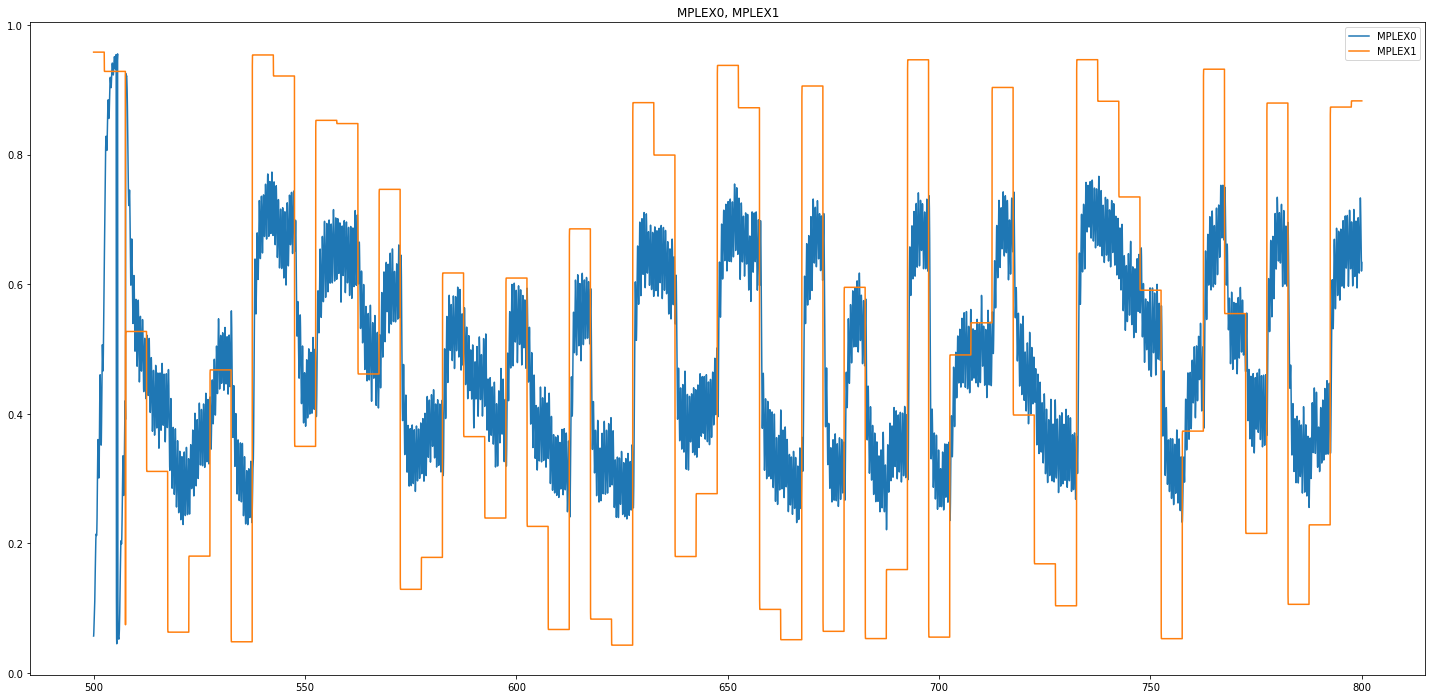

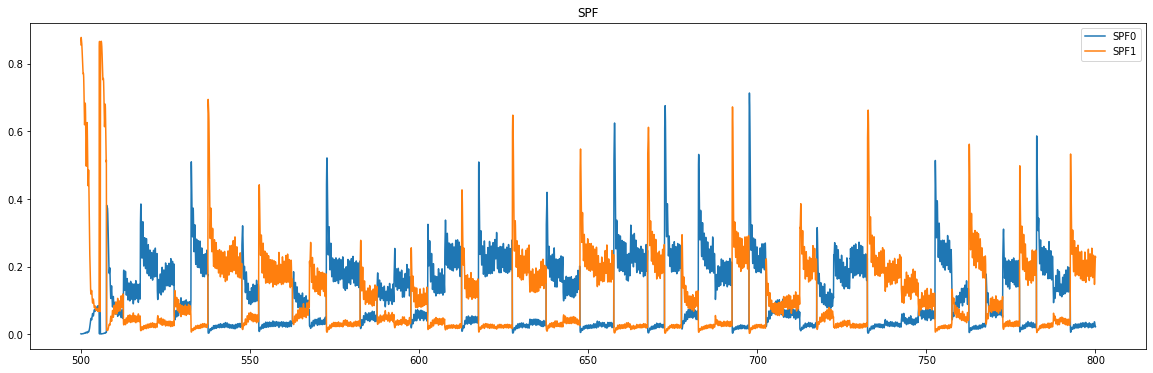

In [36]:
# X
X_fig = plt.figure(figsize=fs)
X_data = np.array(data[X])
plt.plot(times, X_data.transpose())
plt.ylim([-0.05,1.05])
#plt.legend(['X'])
plt.title('X')

fs = (25,12)
# MPLEX
MPLEX_fig = plt.figure(figsize=fs)
MPLEX_data = np.array(data[MPLEX])
plt.plot(times, MPLEX_data.transpose())
plt.legend(['MPLEX0', 'MPLEX1'])
plt.title('MPLEX0, MPLEX1')

# SPF
fs = (20,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
plt.legend(['SPF0', 'SPF1'])
plt.title('SPF')

Text(0.5, 1.0, 'C1')

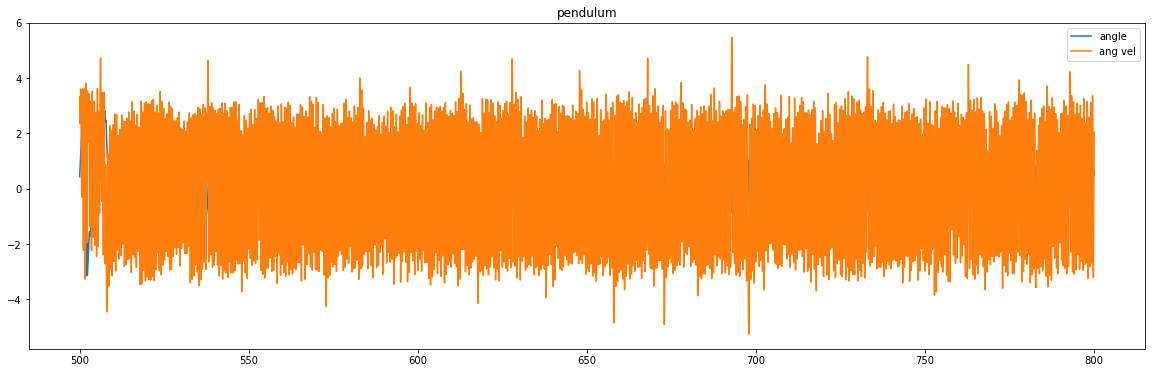

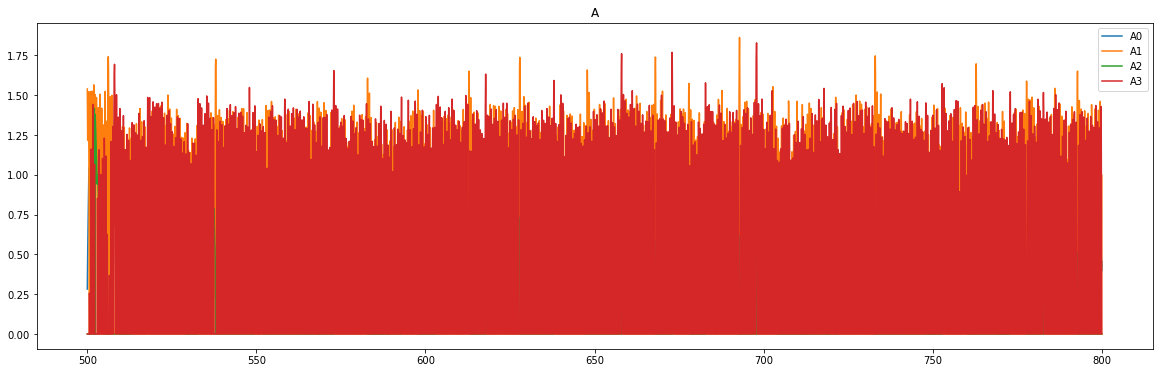

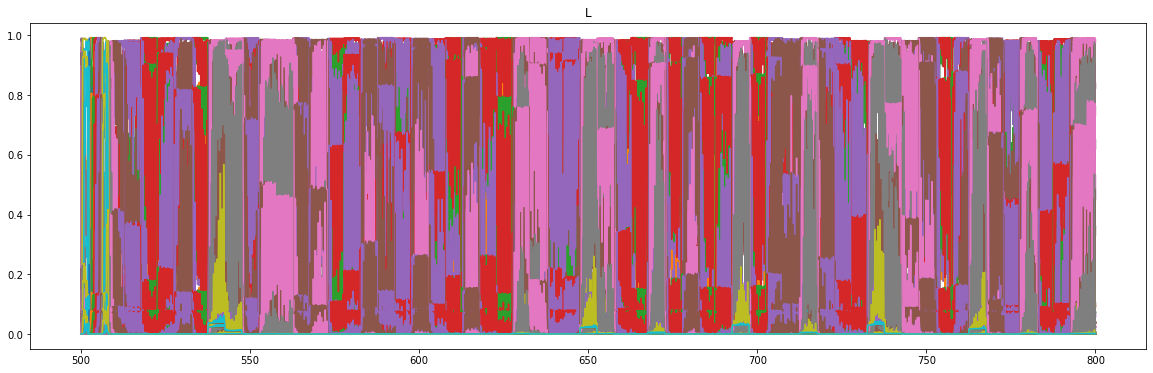

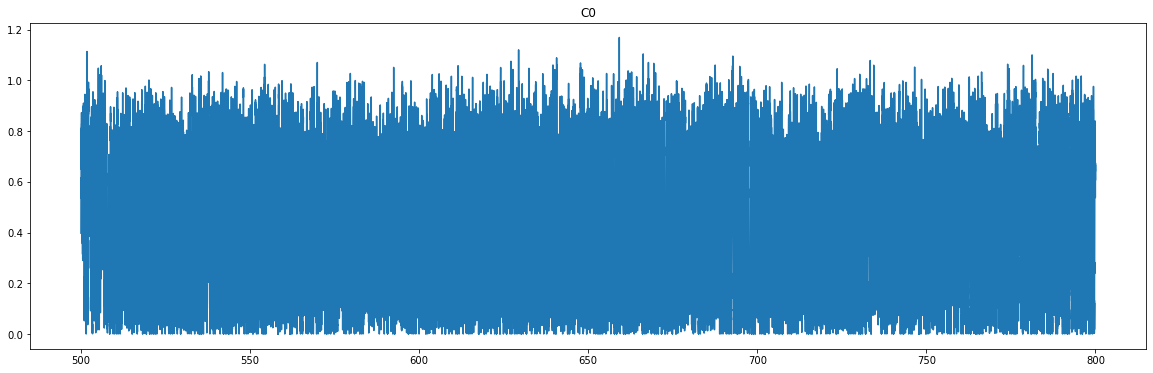

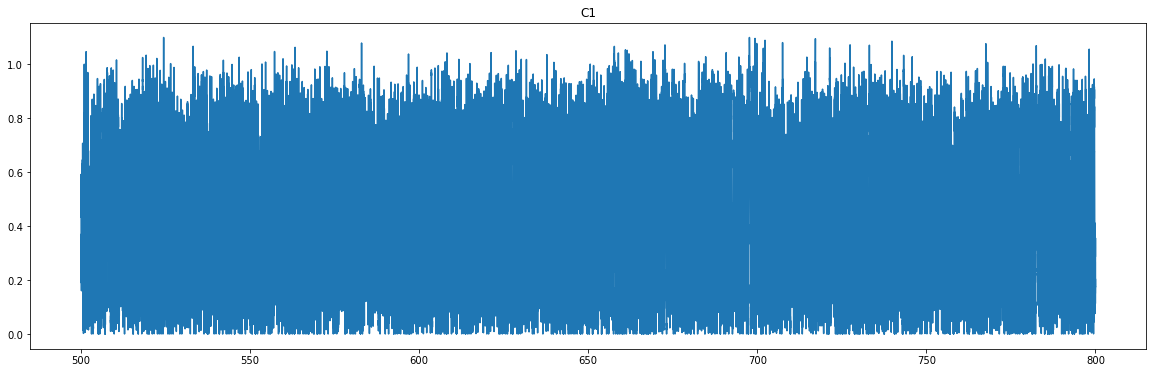

In [37]:
# P
P_fig = plt.figure(figsize=fs)
P_data = plant_data[P]
plt.plot(times, P_data[:,0], label='angle')
plt.plot(times, P_data[:,1], label='ang vel')
plt.legend()
plt.title('pendulum')
#print("angle: %f, vel: %f" % (P_data[-1,0],P_data[-1,1]))

# A
A_fig = plt.figure(figsize=fs)
A_data = np.array(data[A])
plt.plot(times, A_data.transpose())
plt.legend(['A0', 'A1', 'A2', 'A3'])
plt.title('A')
#print(A_data[:,-1])

# L
L_fig = plt.figure(figsize=fs)
L_data = np.array(data[L])
plt.plot(times, L_data.transpose())
plt.title('L')

# C0
C0_fig = plt.figure(figsize=fs)
C0_data = np.array(data[C[0]])
plt.plot(times, C0_data.transpose())
#plt.plot(times, data[dc_track[0]], linewidth=3)
plt.title('C0')
#print(C0_data[-1])

# C1
C1_fig = plt.figure(figsize=fs)
C1_data = np.array(data[C[1]])
plt.plot(times, C1_data.transpose())
#plt.plot(times, data[dc_track[1]], linewidth=3)
plt.title('C1')
#print(C1_data[-1])


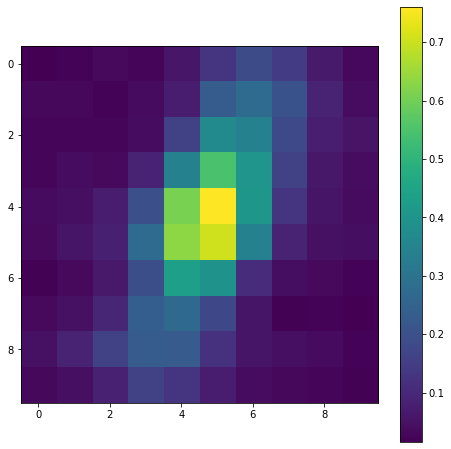

In [38]:
# L__V connections
No2=10
L__V_w_mat = np.zeros((No2, No2))
for i in range(No2):
    for j in range(No2):
        w = net.syns[V[0]][i*No2 + j].w
        #print("%.2f" % (w), end=' ')
        L__V_w_mat[i,No2-j-1] = w
    #print("\n")
    
L__V_w_mat_fig = plt.figure(figsize=(8,8))
axs = plt.subplot(1,1,1)
cs = axs.imshow(L__V_w_mat)
L__V_w_mat_fig.colorbar(cs)
plt.show()

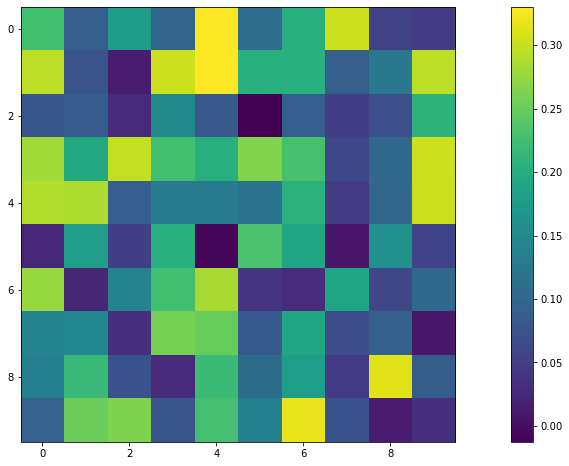

In [39]:
# L__X connections
matty0 = np.zeros((No2, No2))
matty1 = np.zeros((No2, No2))
for i in range(No2):
    for j in range(No2):
        w0 = net.syns[X[0]][i*No2 + j].w
        #w1 = net.syns[X[1]][i*No2 + j+4].w
        #print("%.2f" % (w), end=' ')
        matty0[i,No2-j-1] = w0
        #matty1[i,No2-j-1] = w1
    #print("\n")
    
matty_fig = plt.figure(figsize=(20,8))
axs0 = plt.subplot(1,1,1)
cs0 = axs0.imshow(matty0)
plt.colorbar(cs0)
# axs1 = plt.subplot(1,2,2)
# cs1 = axs1.imshow(matty1)
# plt.colorbar(cs1)
plt.show()

In [7]:
plotty = plotter(net, times, data)

In [12]:
plotty.act_anim(S1+S2+L+R+V, 0.5, interv=10, slider=False)

In [8]:
plotty.conn_anim(L, V)

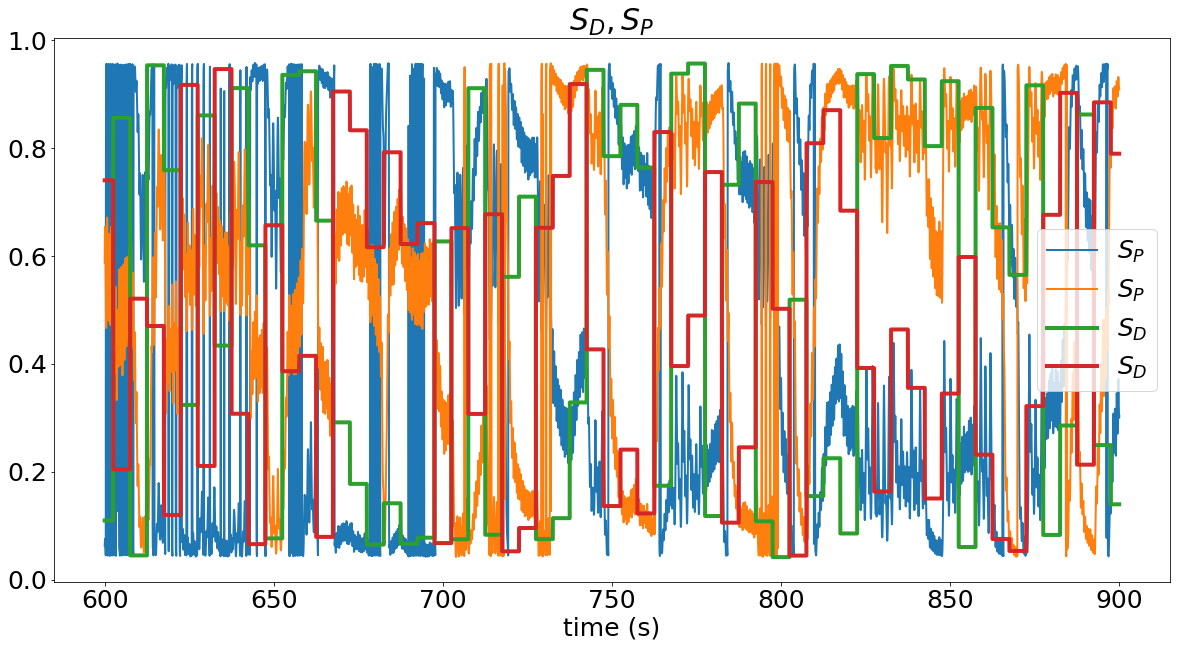

In [25]:
# A figure with more formatting
SPF_fig = plt.figure(figsize=(20,10))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='$S_P$', linewidth=2)
plt.plot(times, SP_data.transpose(), label='$S_D$', linewidth=4)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.xlabel('time (s)', fontsize =25)
plt.title('$S_D, S_P$', fontsize=30)
plt.show()

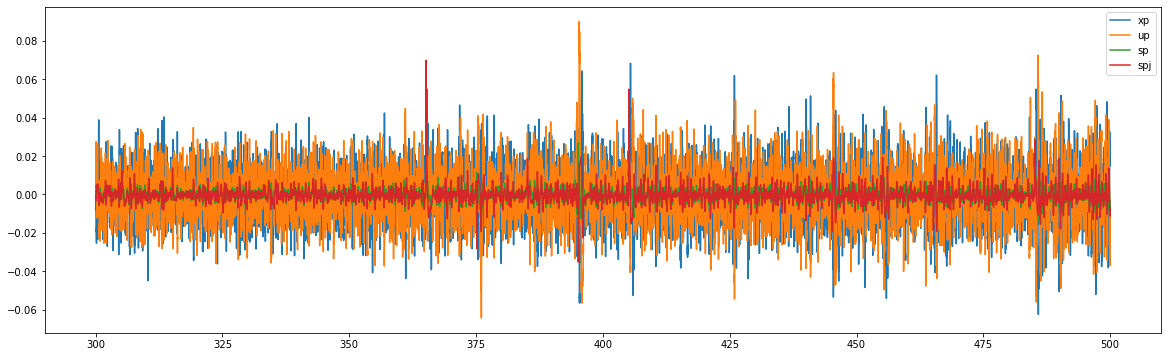

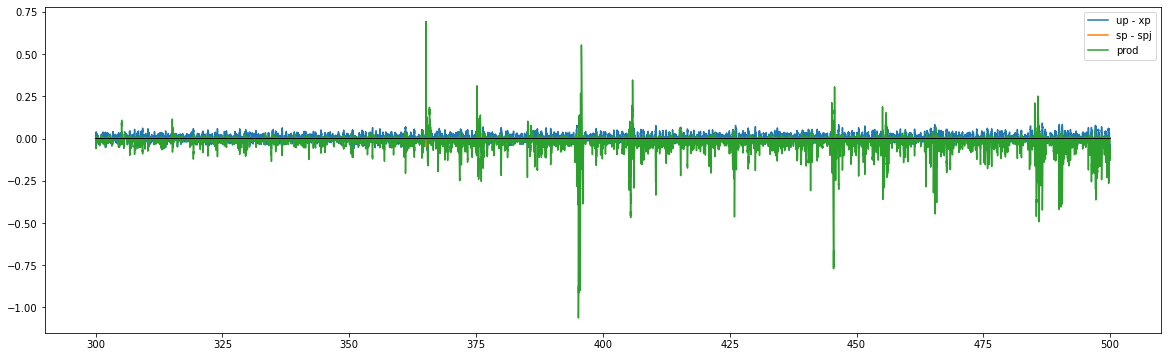

In [21]:
# plot all factors in the M--C0 synaptic plasticity
fs = (20,6)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_data = np.array(data[sp_track[0]])
spj_data = np.array(data[spj_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_data)
plt.plot(times, spj_data)
plt.legend(['xp', 'up', 'sp', 'spj'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
f2 = sp_data - spj_data
rule = 500. * f1 * f2
plt.plot(times, f1)
plt.plot(times, f2)
plt.plot(times, rule)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'sp - spj', 'prod'])
plt.show()

In [45]:
# checking some connections
print("Connections to M0 unit")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    #elif pre_id in L:
    #    pre_pop = 'L'
    elif pre_id in M:
        pre_pop = 'M'
    #elif pre_id in V:
    #    pre_pop = 'V'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M0, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to M1 unit")
for idx, syn in enumerate(net.syns[M[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    #elif pre_id in L:
    #    pre_pop = 'L'
    elif pre_id in M:
        pre_pop = 'M'
    #elif pre_id in V:
    #    pre_pop = 'V'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M1, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
    
print("Connections to C0 unit")
for idx, syn in enumerate(net.syns[C[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> C0, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))  

print("Connections to C1 unit")
for idx, syn in enumerate(net.syns[C[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> C1, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))  

    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[A[2]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))
    
print("Connections to X units")
for idx, syn in enumerate(net.syns[X[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in L:
        pre_pop = 'L'
    elif pre_id in V:
        pre_pop = 'V'
    else:
        pre_pop = 'erroneous'
    #print('%d) %s (%d) --> X, w=%f, port=%d'%(idx, pre_pop, pre_id, syn.w, syn.port))  

print("Connections to MPLEX units")
for idx, syn in enumerate(net.syns[MPLEX[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in X:
        pre_pop = 'X'
    elif pre_id in SF:
        pre_pop = 'SF'
    elif pre_id in SP:
        pre_pop = 'SP'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> MPLEX, w=%f, port=%d'%(idx, pre_pop, pre_id, syn.w, syn.port))  

print("Connections to SF units")
for idx, syn in enumerate(net.syns[SF[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in T:
        pre_pop = 'T'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> SF, w=%f, port=%d, plant_out=%s'%
          (idx, pre_pop, pre_id, syn.w, syn.port, plant_out))


Connections to M0 unit
0) A (0) --> M0, w=0.386841, port=2, plant_out=None
1) A (1) --> M0, w=0.492826, port=2, plant_out=None
2) A (2) --> M0, w=0.020318, port=2, plant_out=None
3) A (3) --> M0, w=0.000000, port=2, plant_out=None
4) M (107) --> M0, w=-1.000000, port=3, plant_out=None
5) SPF (155) --> M0, w=1.000000, port=1, plant_out=None
Connections to M1 unit
0) A (0) --> M1, w=0.006995, port=2, plant_out=None
1) A (1) --> M1, w=0.000000, port=2, plant_out=None
2) A (2) --> M1, w=0.396099, port=2, plant_out=None
3) A (3) --> M1, w=0.496907, port=2, plant_out=None
4) M (106) --> M1, w=-1.000000, port=3, plant_out=None
5) SPF (156) --> M1, w=1.000000, port=1, plant_out=None
Connections to C0 unit
0) C (5) --> C0, w=-1.500000, port=1, plant_out=None
1) M (106) --> C0, w=0.000000, port=0, plant_out=None
2) M (107) --> C0, w=2.172420, port=0, plant_out=None
Connections to C1 unit
0) C (4) --> C1, w=-1.500000, port=1, plant_out=None
1) M (106) --> C1, w=2.173493, port=0, plant_out=None
2)

In [6]:
# Setting a static value for X
net.units[X[0]].thresh = -10. # high threshold makes output zero

NameError: name 'X' is not defined

In [4]:
# good initial weights

# M__C
# M[0] has the F-D error, so you want C[0] (which exerts positive torque)
# to be driven by M[1] instead, and C[1] to be driven by M[0]
shift = 0
while not net.syns[C[0]][shift].type is synapse_types.rga:
    shift += 1
net.syns[C[0]][shift].w = 0.1
net.syns[C[0]][shift+1].w = 0.8 # C[0] driven by M[1]
net.syns[C[1]][shift].w = 0.8
net.syns[C[1]][shift+1].w = 0.1

# L__X, L__V
scale = 1. # maximum weight value
def dist(c1, c2):
    """ Periodic distance between 2-dim coordinates c1 and c2. 

        Assumes c1 and c2 are inside the box with corners [-0.5, -0.5], [0.5, 0.5].
    """
    x_dist = min(max(c1[0], c2[0]) - min(c1[0], c2[0]),  # "inner" distance
                 0.5-max(c1[0], c2[0]) + (min(c1[0], c2[0])+0.5) ) # "outer" distance
    y_dist = min(max(c1[1], c2[1]) - min(c1[1], c2[1]),  # "inner" distance
                 0.5-max(c1[1], c2[1]) + (min(c1[1], c2[1])+0.5) ) # "outer" distance
    return np.sqrt(x_dist*x_dist + y_dist*y_dist)

#L__V_iw = np.zeros((No2, No2))
j = 0
for i in range(len(L)):  # Setting L__V weights
    u = net.units[L[i]]
    c = u.coordinates
    d = dist(c, [c[1], c[1]])
    Vsyn = net.syns[V[0]][i]
    Xsyn = net.syns[X[0]][i+j]
    while Xsyn.type != synapse_types.diff_rm_hebbian:
        j +=1
        Xsyn = net.syns[X[0]][i+j]
    if Vsyn.preID == u.ID and Xsyn.preID == u.ID:
        a, b = divmod(i, No2)
        Vsyn.w = scale*(.5 - d)
        Xsyn.w = 0.01 if abs(c[1]-c[0]) < 0.5-max(c[1],c[0]) + min(c[1],c[0])+0.5 else .8
    else:
        print("FAILED!!!!!!!")

IndexError: list index out of range

---